In [3]:
import os
from functools import partial
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import pyro.distributions as dist
import pyro
from pyro.distributions import Normal, Uniform, Delta
from pyro.optim import Adam
from pyro.distributions.util import logsumexp
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS,HMC
import pyro.optim as optim
import pyro.poutine as poutine

pyro.enable_validation(True)
pyro.set_rng_seed(94)
pyro.enable_validation(True)

## ベイズ線形回帰を無情報事前分布を用いてベイズ推定[Pyro 実装]
### 1) 線形回帰のパラメータWが無情報事前分布の場合
### 2)パラメータwの分布の分散パラメータが無情報の場合
### 3)パラメータwの分布の分散パラメータに誤った信念を入れた場合

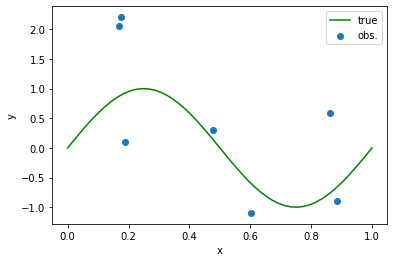

In [35]:
#5次多項式モデル
def func(x):
    return np.sin(2*np.pi*x)
#dataset
train_size =7
M =5
X=np.zeros([M,train_size])
X[0] = np.random.rand(train_size)
X[1] = X[0]**2
X[2] = X[0]**3
X[3] = X[0]**4
X[4] = X[0]**5
y = func(X[0])+np.random.randn(train_size)*0.8#[10,]
plt.scatter(X[0],y,label="obs.")

plt.plot(np.linspace(0,1),func(np.linspace(0,1)),c='g',label="true")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()


In [36]:
X_train = torch.tensor(X,dtype = torch.float).T
y_train = torch.tensor(y,dtype = torch.float).unsqueeze(-1)
X_train.size(),y_train.size()

(torch.Size([7, 5]), torch.Size([7, 1]))

In [37]:
y_train

tensor([[ 0.0913],
        [ 0.5921],
        [ 2.0608],
        [-1.1001],
        [-0.8884],
        [ 0.3101],
        [ 2.2072]])

### ベイズ線形回帰　w無情報事前分布

In [38]:
"""wの事前分布を無情報事前分布にした場合"""
def model(X, y):
    #パラメータのサンプリングを生成的にかく
    w = pyro.sample("w", dist.Normal(torch.zeros([M]), 100000*torch.ones([M])))
    sigma = pyro.sample("sigma", dist.Uniform(0., 1.))
    mean = torch.sum(X*w,axis=1)
    #with pyro.plate("data", len(y)):
     #   pyro.sample("obs", dist.Normal(mean, 0.001), obs=y)
    for i in range(len(y)):
        pyro.sample("obs_{}".format(i), dist.Normal(mean[i], 0.3), obs=y[i])

In [39]:
nuts_kernel =NUTS(model)#HMC(model, step_size=0.0855, num_steps=4)#NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=250, warmup_steps=50)
mcmc.run(X_train, y_train)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

sample: 100%|██████████| 300/300 [09:22,  1.87s/it, step size=2.35e-03, acc. prob=0.898]


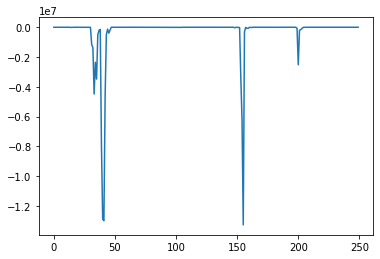

In [41]:
list_log =[]
for i in range(250):
    log_prop = torch.sum(dist.Normal(torch.zeros([M]), 100000*torch.ones([M])).log_prob(torch.tensor(hmc_samples["w"][i])))
    #log_prop += dist.Normal(0., 10000.).log_prob(torch.tensor(hmc_samples["bias"][i]))
    mean = torch.sum(X_train*torch.tensor(hmc_samples["w"][i]),axis=1)
    sigma = hmc_samples["sigma"][i]
    log_prop += dist.Uniform(0., 1.).log_prob(torch.tensor(hmc_samples["sigma"][i]))
    log_prop += torch.sum(dist.Normal(mean, sigma).log_prob(y_train))
    list_log.append(log_prop)
    log_prop = 0
plt.plot(list_log)

In [42]:
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
     
    return site_stats

for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: w
         mean         std          5%         25%         50%         75%  \
0   10.150343   10.660070  -10.532031    3.248867   11.366134   17.039726   
1   28.871120  105.912186 -120.275873  -40.244569   18.007056   90.282639   
2 -295.534119  334.537750 -990.901871 -465.648781 -261.331009  -45.965093   
3  526.717224  429.352997 -121.814611  225.410332  515.697998  744.460312   
4 -276.724396  194.561554 -657.778925 -389.316803 -268.835739 -134.326607   

           95%  
0    25.277502  
1   245.649844  
2   209.393183  
3  1392.808887  
4    19.915309   

Site: sigma
       mean       std        5%       25%       50%       75%       95%
0  0.477187  0.323197  0.008227  0.173847  0.446187  0.767118  0.949906 



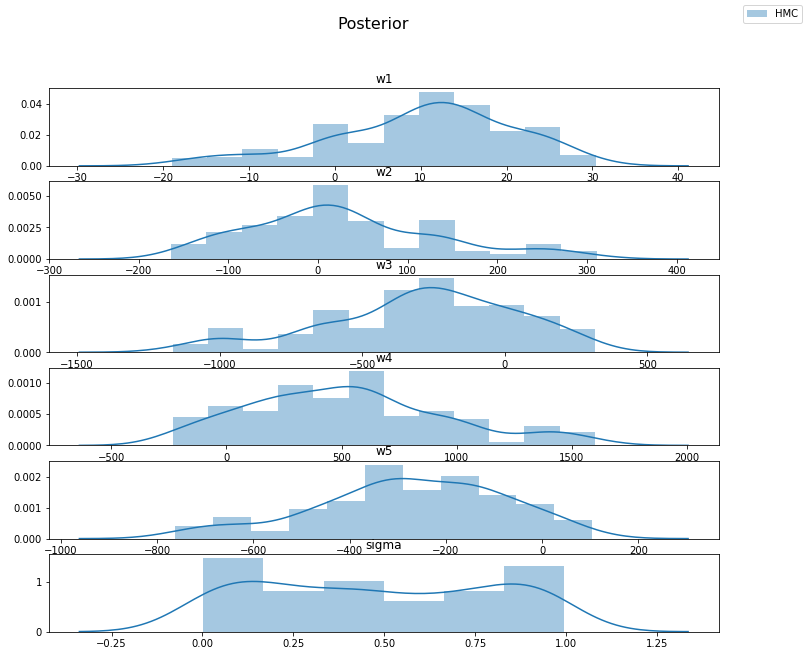

In [43]:
sites = ["w1","w2","w3","w4","w5","sigma"]
fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(12, 10))
fig.suptitle("Posterior", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    if(sites[i]=="w1"):
        sns.distplot(hmc_samples["w"].T[0], ax=ax, label="HMC")
    elif(sites[i]=="w2"):
        sns.distplot(hmc_samples["w"].T[1], ax=ax, label="HMC")
    elif(sites[i]=="w3"):
        sns.distplot(hmc_samples["w"].T[2], ax=ax, label="HMC")
    elif(sites[i]=="w4"):
        sns.distplot(hmc_samples["w"].T[3], ax=ax, label="HMC")
    elif(sites[i]=="w5"):
        sns.distplot(hmc_samples["w"].T[4], ax=ax, label="HMC")
    else:
        sns.distplot(hmc_samples[site], ax=ax, label="HMC")
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

No handles with labels found to put in legend.


<Figure size 432x432 with 0 Axes>

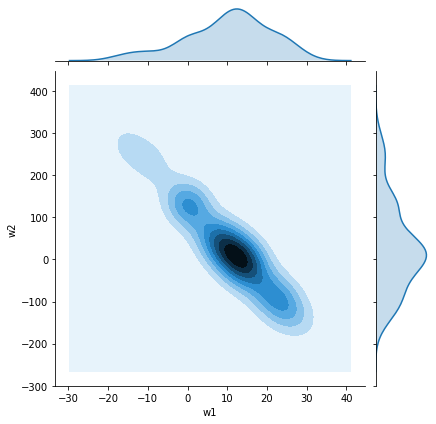

In [44]:
fig = plt.figure(figsize=(6, 6))
#fig.title("Cross-section of the Posterior Distribution", fontsize=16)
df = pd.DataFrame([hmc_samples["w"].T[0], hmc_samples["w"].T[1]]).T
df.columns=["w1","w2"]

sns.jointplot('w1','w2',df, kind="kde", label="HMC")


fig.legend( loc='upper right')

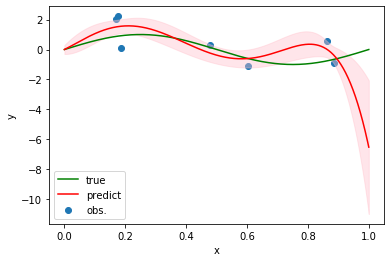

In [45]:
#予測分布のプロット
site_stats = {}
X_test=np.zeros([M,500])
X_test[0] = np.linspace(0,1,500)
X_test[1] = X_test[0]**2
X_test[2] = X_test[0]**3
X_test[3] = X_test[0]**4
X_test[4] = X_test[0]**5
X_test =X_test.T
mean=[]
std=[]
for i in range(len(X_test)):#sample_size
    mean.append(np.mean(np.sum(X_test[i]*hmc_samples["w"],axis=1)))
    std.append(np.std(np.sum(X_test[i]*hmc_samples["w"],axis=1)))
mean = np.array(mean)
std = np.array(std)+0.3#+np.mean(hmc_samples["sigma"])

plt.scatter(X[0],y,label="obs.")
x = np.linspace(0,1,500)
plt.plot(x,func(x),c='g',label="true")
plt.plot(x,mean ,c='r',label="predict")
plt.fill_between(x, mean + std, mean- std,
                color='pink', alpha=0.4)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

### 階層ベイズモデル ガンマ分布（無情報事前分布）

In [46]:
 "階層ベイズにしてガンマ分布を無情報事前分布"
def model2(X, y):
    #パラメータのサンプリングを生成的にかく
    gamma = pyro.sample("gamma", dist.Gamma(concentration=0.0001, rate=0.0001))#無情報事前分布
    #bias = pyro.sample("bias", dist.Normal(0., 1/gamma))
    w = pyro.sample("w", dist.Normal(torch.zeros([M]), (1/gamma)*torch.ones([M])))
    
    sigma = pyro.sample("sigma", dist.Uniform(0., 1.))
    mean = torch.sum(X*w,axis=1)
    for i in range(len(y)):
        pyro.sample("obs_{}".format(i), dist.Normal(mean[i], 0.3), obs=y[i])
    

In [47]:
nuts_kernel =NUTS(model2)#HMC(model, step_size=0.0855, num_steps=4)#NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=250, warmup_steps=50)
mcmc.run(X_train, y_train)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

sample: 100%|██████████| 300/300 [07:41,  1.54s/it, step size=7.15e-03, acc. prob=0.946]


In [48]:
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
     
    return site_stats

for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: gamma
       mean      std       5%       25%       50%       75%       95%
0  0.038599  0.02243  0.00949  0.021262  0.034727  0.051215  0.085048 

Site: w
        mean        std         5%        25%        50%        75%        95%
0  14.852226   3.179476  10.575320  12.264256  14.548589  17.073379  20.229825
1 -43.691090  19.369720 -77.661581 -56.065882 -40.485600 -29.332194 -17.309736
2  18.022202  29.253443 -18.605144  -2.209662  14.195960  35.949946  71.860893
3  25.808380  33.960781 -16.075669   6.862177  18.573332  38.993416  83.256571
4 -13.617655  29.889278 -72.261665 -28.485853  -5.639211   8.097386  18.425033 

Site: sigma
       mean       std        5%       25%       50%       75%       95%
0  0.540793  0.289137  0.078174  0.280827  0.564376  0.813441  0.950656 



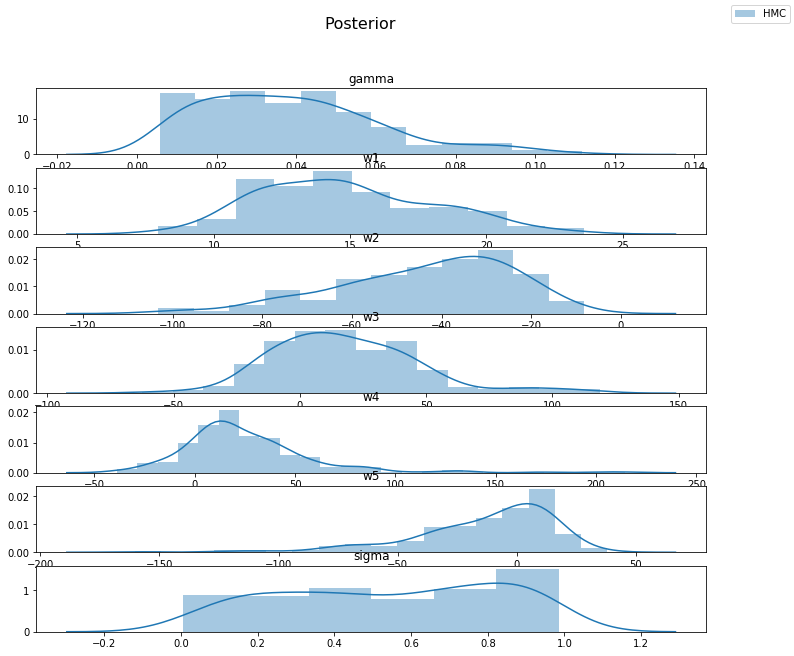

In [49]:

sites = ["gamma", "w1","w2", "w3","w4","w5","sigma"]
fig, axs = plt.subplots(nrows=7, ncols=1, figsize=(12, 10))
fig.suptitle("Posterior", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    if(sites[i]=="w1"):
        sns.distplot(hmc_samples["w"].T[0], ax=ax, label="HMC")
    elif(sites[i]=="w2"):
        sns.distplot(hmc_samples["w"].T[1], ax=ax, label="HMC")
    elif(sites[i]=="w3"):
        sns.distplot(hmc_samples["w"].T[2], ax=ax, label="HMC")
    elif(sites[i]=="w4"):
        sns.distplot(hmc_samples["w"].T[3], ax=ax, label="HMC")
    elif(sites[i]=="w5"):
        sns.distplot(hmc_samples["w"].T[4], ax=ax, label="HMC")
    else:
        sns.distplot(hmc_samples[site], ax=ax, label="HMC")
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

No handles with labels found to put in legend.


<Figure size 432x432 with 0 Axes>

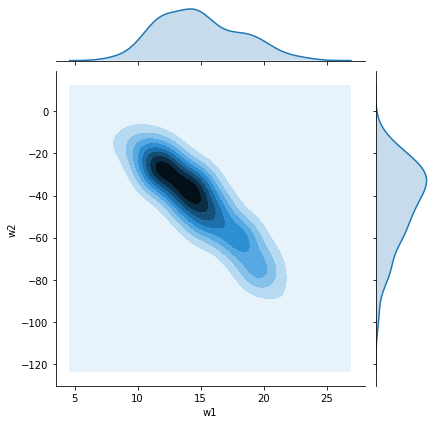

In [50]:
fig = plt.figure(figsize=(6, 6))
#fig.title("Cross-section of the Posterior Distribution", fontsize=16)
df = pd.DataFrame([hmc_samples["w"].T[0], hmc_samples["w"].T[1]]).T
df.columns=["w1","w2"]

sns.jointplot('w1','w2',df, kind="kde", label="HMC")


fig.legend( loc='upper right')

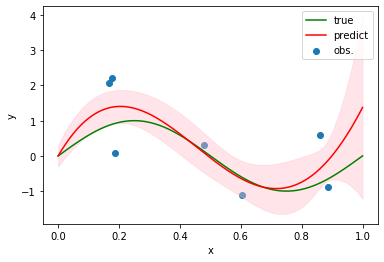

In [51]:
#予測分布のプロット
site_stats = {}
X_test=np.zeros([M,500])
X_test[0] = np.linspace(0,1,500)
X_test[1] = X_test[0]**2
X_test[2] = X_test[0]**3
X_test[3] = X_test[0]**4
X_test[4] = X_test[0]**5
X_test =X_test.T
mean=[]
std=[]
for i in range(len(X_test)):#sample_size
    mean.append(np.mean(np.sum(X_test[i]*hmc_samples["w"],axis=1)))
    std.append(np.std(np.sum(X_test[i]*hmc_samples["w"],axis=1)))
    
#mean = np.mean(hmc_samples["bias"])+mean
#std = np.std(hmc_samples["bias"])+std
mean = np.array(mean)
std = np.array(std)+0.3#+np.mean(hmc_samples["sigma"])
plt.scatter(X[0],y,label="obs.")
x = np.linspace(0,1,500)
plt.plot(x,func(x),c='g',label="true")
plt.plot(x,mean ,c='r',label="predict")
plt.fill_between(x, mean + std, mean - std,color='pink', alpha=0.4)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

### 線形ベイズ回帰モデル

In [52]:
"階層ベイズにしてガンマ分布に誤った信念を入れたとき"
def model3(X, y):
    #パラメータのサンプリングを生成的にかく
    #bias = pyro.sample("bias", dist.Normal(0., 1.))
    w = pyro.sample("w", dist.Normal(torch.zeros([M]), torch.ones([M])))

    sigma = pyro.sample("sigma", dist.Uniform(0., 1.))
    mean = torch.sum(X*w,axis=1)
    for i in range(len(y)):
        pyro.sample("obs_{}".format(i), dist.Normal(mean[i], 0.3), obs=y[i])

In [53]:
nuts_kernel =NUTS(model3)#HMC(model, step_size=0.0855, num_steps=4)#NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=250, warmup_steps=50)
mcmc.run(X_train, y_train)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

sample: 100%|██████████| 300/300 [00:34,  8.71it/s, step size=9.07e-02, acc. prob=0.981]


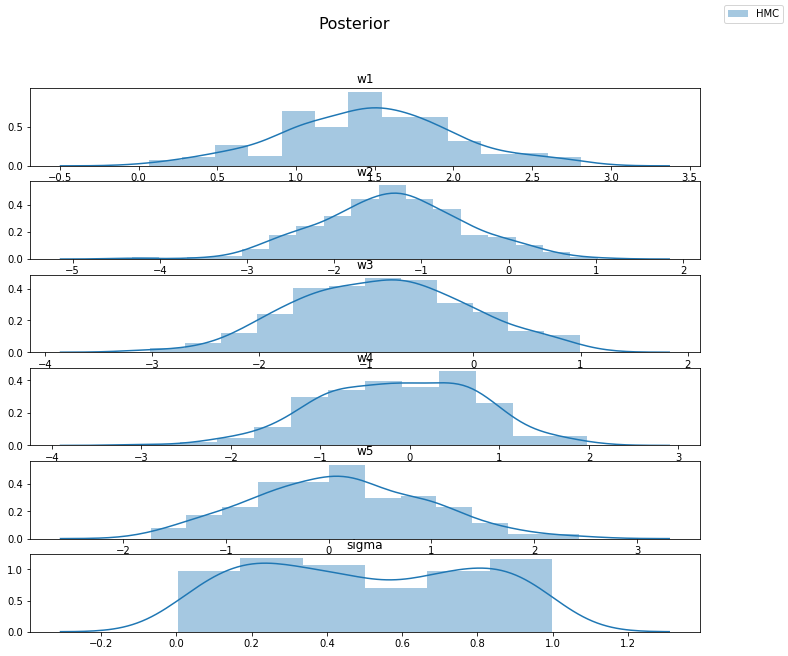

In [54]:
sites = [ "w1","w2","w3","w4","w5", "sigma"]
fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(12, 10))
fig.suptitle("Posterior", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    if(sites[i]=="w1"):
        sns.distplot(hmc_samples["w"].T[0], ax=ax, label="HMC")
    elif(sites[i]=="w2"):
        sns.distplot(hmc_samples["w"].T[1], ax=ax, label="HMC")
    elif(sites[i]=="w3"):
        sns.distplot(hmc_samples["w"].T[2], ax=ax, label="HMC")
    elif(sites[i]=="w4"):
        sns.distplot(hmc_samples["w"].T[3], ax=ax, label="HMC")
    elif(sites[i]=="w5"):
        sns.distplot(hmc_samples["w"].T[4], ax=ax, label="HMC")
    else:
        sns.distplot(hmc_samples[site], ax=ax, label="HMC")
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

No handles with labels found to put in legend.


<Figure size 432x432 with 0 Axes>

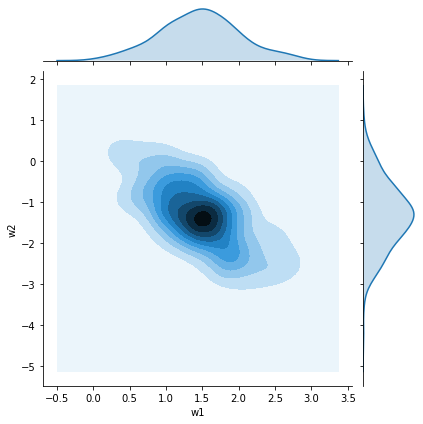

In [55]:
fig = plt.figure(figsize=(6, 6))
#fig.title("Cross-section of the Posterior Distribution", fontsize=16)
df = pd.DataFrame([hmc_samples["w"].T[0], hmc_samples["w"].T[1]]).T
df.columns=["w1","w2"]

sns.jointplot('w1','w2',df, kind="kde", label="HMC")


fig.legend( loc='upper right')

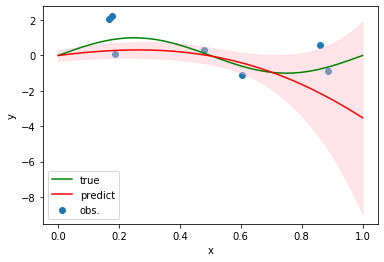

In [56]:
#予測分布のプロット
site_stats = {}
X_test=np.zeros([M,500])
X_test[0] = np.linspace(0,1.5,500)
X_test[1] = X_test[0]**2
X_test[2] = X_test[0]**3
X_test[3] = X_test[0]**4
X_test[4] = X_test[0]**5
X_test =X_test.T
mean=[]
std=[]
for i in range(len(X_test)):#sample_size
    mean.append(np.mean(np.sum(X_test[i]*hmc_samples["w"],axis=1)))
    std.append(np.std(np.sum(X_test[i]*hmc_samples["w"],axis=1)))
mean = np.array(mean)
std = np.array(std)+0.3#np.mean(hmc_samples["sigma"])

plt.scatter(X[0],y,label="obs.")
x = np.linspace(0,1,500)
plt.plot(x,func(x),c='g',label="true")
plt.plot(x,mean ,c='r',label="predict")
plt.fill_between(x, mean + std, mean- std,
                color='pink', alpha=0.4)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()